# Pronóstico de OT (ETT) sin estacionalidad — 100 pasos sin regresores futuros

**Objetivo:** Seleccionar un dataset multivariante no financiero (ETT), comprobar que la variable objetivo **OT** (Oil Temperature) no tiene estacionalidad y construir **~5 modelos** para predecir **100 pasos** en el futuro **sin acceso a regresores futuros** desde el instante de predicción. Evaluar con KPIs (MAE, RMSE, MAPE), guardar el mejor modelo y mostrar una demo de uso.

**Dataset:** ETT-small `ETTh1.csv` (horario), columnas: `date`, `HUFL`, `HULL`, `MUFL`, `MULL`, `LUFL`, `LULL`, `OT`.

**Fuente:** https://github.com/zhouhaoyi/ETDataset

## 1. Preparación del entorno

In [6]:
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport


from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error

import joblib

# Local utils
sys.path.append(str(Path.cwd() / "src"))


BASE_DIR = Path('.').resolve().parent if (Path('.').resolve().name == 'notebooks') else Path('.').resolve()
DATA_RAW = BASE_DIR / 'data' / 'raw'
ARTIFACTS = BASE_DIR / 'artifacts'
REPORTS = BASE_DIR / 'reports'
FIGURES = REPORTS / 'figures'
RANDOM_STATE = 42

# Crear directorios si no existen
for p in [DATA_RAW, ARTIFACTS, REPORTS, FIGURES]:
    p.mkdir(parents=True, exist_ok=True)

## 2. Descarga o carga del dataset

In [7]:
import urllib.request

url = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv"
csv_path = DATA_RAW / "ETTh1.csv"
if not csv_path.exists():
    print("Descargando ETTh1.csv...")
    urllib.request.urlretrieve(url, csv_path)

df = pd.read_csv(csv_path, parse_dates=["date"])
df = df.sort_values("date").reset_index(drop=True)
df.head()

date   HUFL   HULL   MUFL   MULL   LUFL   LULL         OT
0 2016-07-01 00:00:00  5.827  2.009  1.599  0.462  4.203  1.340  30.531000
1 2016-07-01 01:00:00  5.693  2.076  1.492  0.426  4.142  1.371  27.787001
2 2016-07-01 02:00:00  5.157  1.741  1.279  0.355  3.777  1.218  27.787001
3 2016-07-01 03:00:00  5.090  1.942  1.279  0.391  3.807  1.279  25.044001
4 2016-07-01 04:00:00  5.358  1.942  1.492  0.462  3.868  1.279  21.948000

## 3. Exploración y selección de la variable objetivo

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17420 entries, 0 to 17419
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    17420 non-null  datetime64[ns]
 1   HUFL    17420 non-null  float64       
 2   HULL    17420 non-null  float64       
 3   MUFL    17420 non-null  float64       
 4   MULL    17420 non-null  float64       
 5   LUFL    17420 non-null  float64       
 6   LULL    17420 non-null  float64       
 7   OT      17420 non-null  float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 1.1 MB


No hay valores nulos, veamos un análisis más exhaustivo con ProfileReport

In [9]:
report = ProfileReport(df)
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 48.87it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Podemos remarcar varias cosas sobre el análisis realizado con Profile Report.

En primer lugar, si observamos la matriz de correlación, las variables HUFL (High UseFul Load) y MUFL (Middle UseFul Load) están altamente correlacionadas. Lo mismo ocurre con HULL (High UseLess Load) y MULL (Middle UseLess Load). Por este motivo, eliminaremos las variables MUFL y MULL y nos quedaremos solamente con variables de alta carga y baja carga.

Por otro lado, también tenemos presencia de outliers que impiden una distribución normal.

In [10]:
df_filtered = df.copy()
df_filtered.drop(['MUFL']  ,axis=1, inplace=True, errors = 'ignore')
df_filtered.drop(['MULL'] ,axis=1, inplace=True, errors = 'ignore')

In [11]:
# Función para eliminar outliers
def remove_outliers(df: pd.DataFrame, columns: list, threshold: int =1.5) -> pd.DataFrame:
    """Elimina outliers de un DataFrame utilizando el método del rango intercuartílico (IQR).

    Args:
        df (pd.DataFrame): DataFrame del cual se eliminarán los outliers.
        columns (list): Lista de columnas a evaluar para la eliminación de outliers.
        threshold (int, optional): Umbral por el cual se modifica la sensibilidad del rango (a mayor, menos datos se eliminan). Defaults to 1.5.

    Returns:
        pd.DataFrame: DataFrame sin outliers.
    """
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Remove outliers from the filtered dataset
columns_to_check = ['HUFL', 'HULL', 'LUFL', 'LULL', 'OT']
df_filtered = remove_outliers(df_filtered, columns_to_check, 2)

Veamos de nuevo el report

In [12]:
report_filtered = ProfileReport(df_filtered)
report_filtered

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 226.89it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Ahora ya no hay tanta presencia de outliers y siguen distribuciones gaussianas.

Representaciones interesantes para el estudio:

    - Evolución de **OT** total.
    - Evolución de **OT** por días en el mes.
    - Evolución de **OT** por días en la semana.
    - Evolución de **OT** por meses.

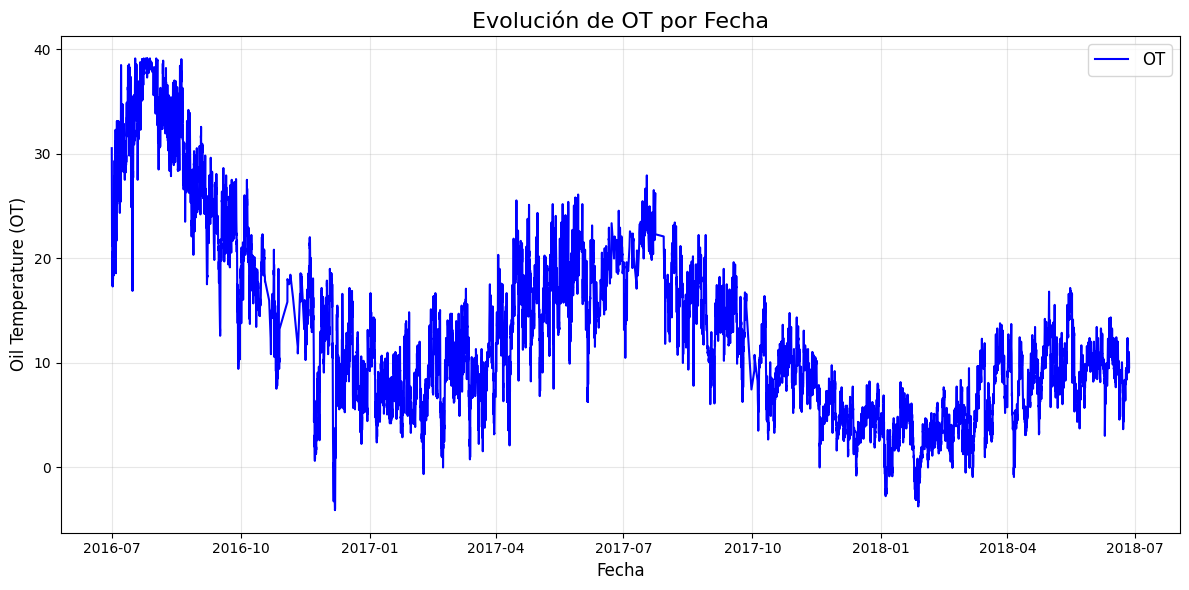

In [13]:
# Evolución de OT total
plt.figure(figsize=(12, 6))
plt.plot(df_filtered["date"], df_filtered["OT"], label="OT", color="blue", linewidth=1.5)
plt.title("Evolución de OT por Fecha", fontsize=16)
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Oil Temperature (OT)", fontsize=12)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig(FIGURES / "ot_evolution.png", dpi=160)
plt.show()

Se observan períodos de mayor temperatura en los meses de verano, con patrones a corto tiempo. Sin embargo, se puede apreciar una tendencia negativa. Veamos más profundamente cada caso.

Plot de la media de OT por día por cada mes durante los dos años.

In [14]:
import math

# Extraemos mes-año, día de la semana y días completos sin hora
df_filtered['YearMonth'] = df_filtered['date'].dt.to_period('M')
df_filtered['Weekday'] = df_filtered['date'].dt.day_name()  # lunes, martes...
df_filtered['Day'] = df_filtered['date'].dt.date
# Si prefieres orden numérico de lunes=0,... domingo=6:
df_filtered['WeekdayNum'] = df_filtered['date'].dt.weekday

# Agrupamos por mes y día de la semana
monthly_daily_mean = df_filtered.groupby(['YearMonth', 'WeekdayNum'])['OT'].mean().reset_index()

# Agrupación por mes
monthly_mean = df_filtered.groupby('YearMonth')['OT'].mean().reset_index()
monthly_mean['YearMonth'] = monthly_mean['YearMonth'].dt.to_timestamp()

# Agrupación por día (pd.Series)
series_daily_mean = df_filtered.set_index('date').resample('D')['OT'].mean()
daily_mean = df_filtered.groupby('Day')[['OT', 'HUFL', 'HULL', 'LUFL', 'LULL']].mean().reset_index()

# Mapeamos el número a nombre del día para el plot ordenado
weekday_map = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
monthly_daily_mean['Weekday'] = monthly_daily_mean['WeekdayNum'].map(weekday_map)

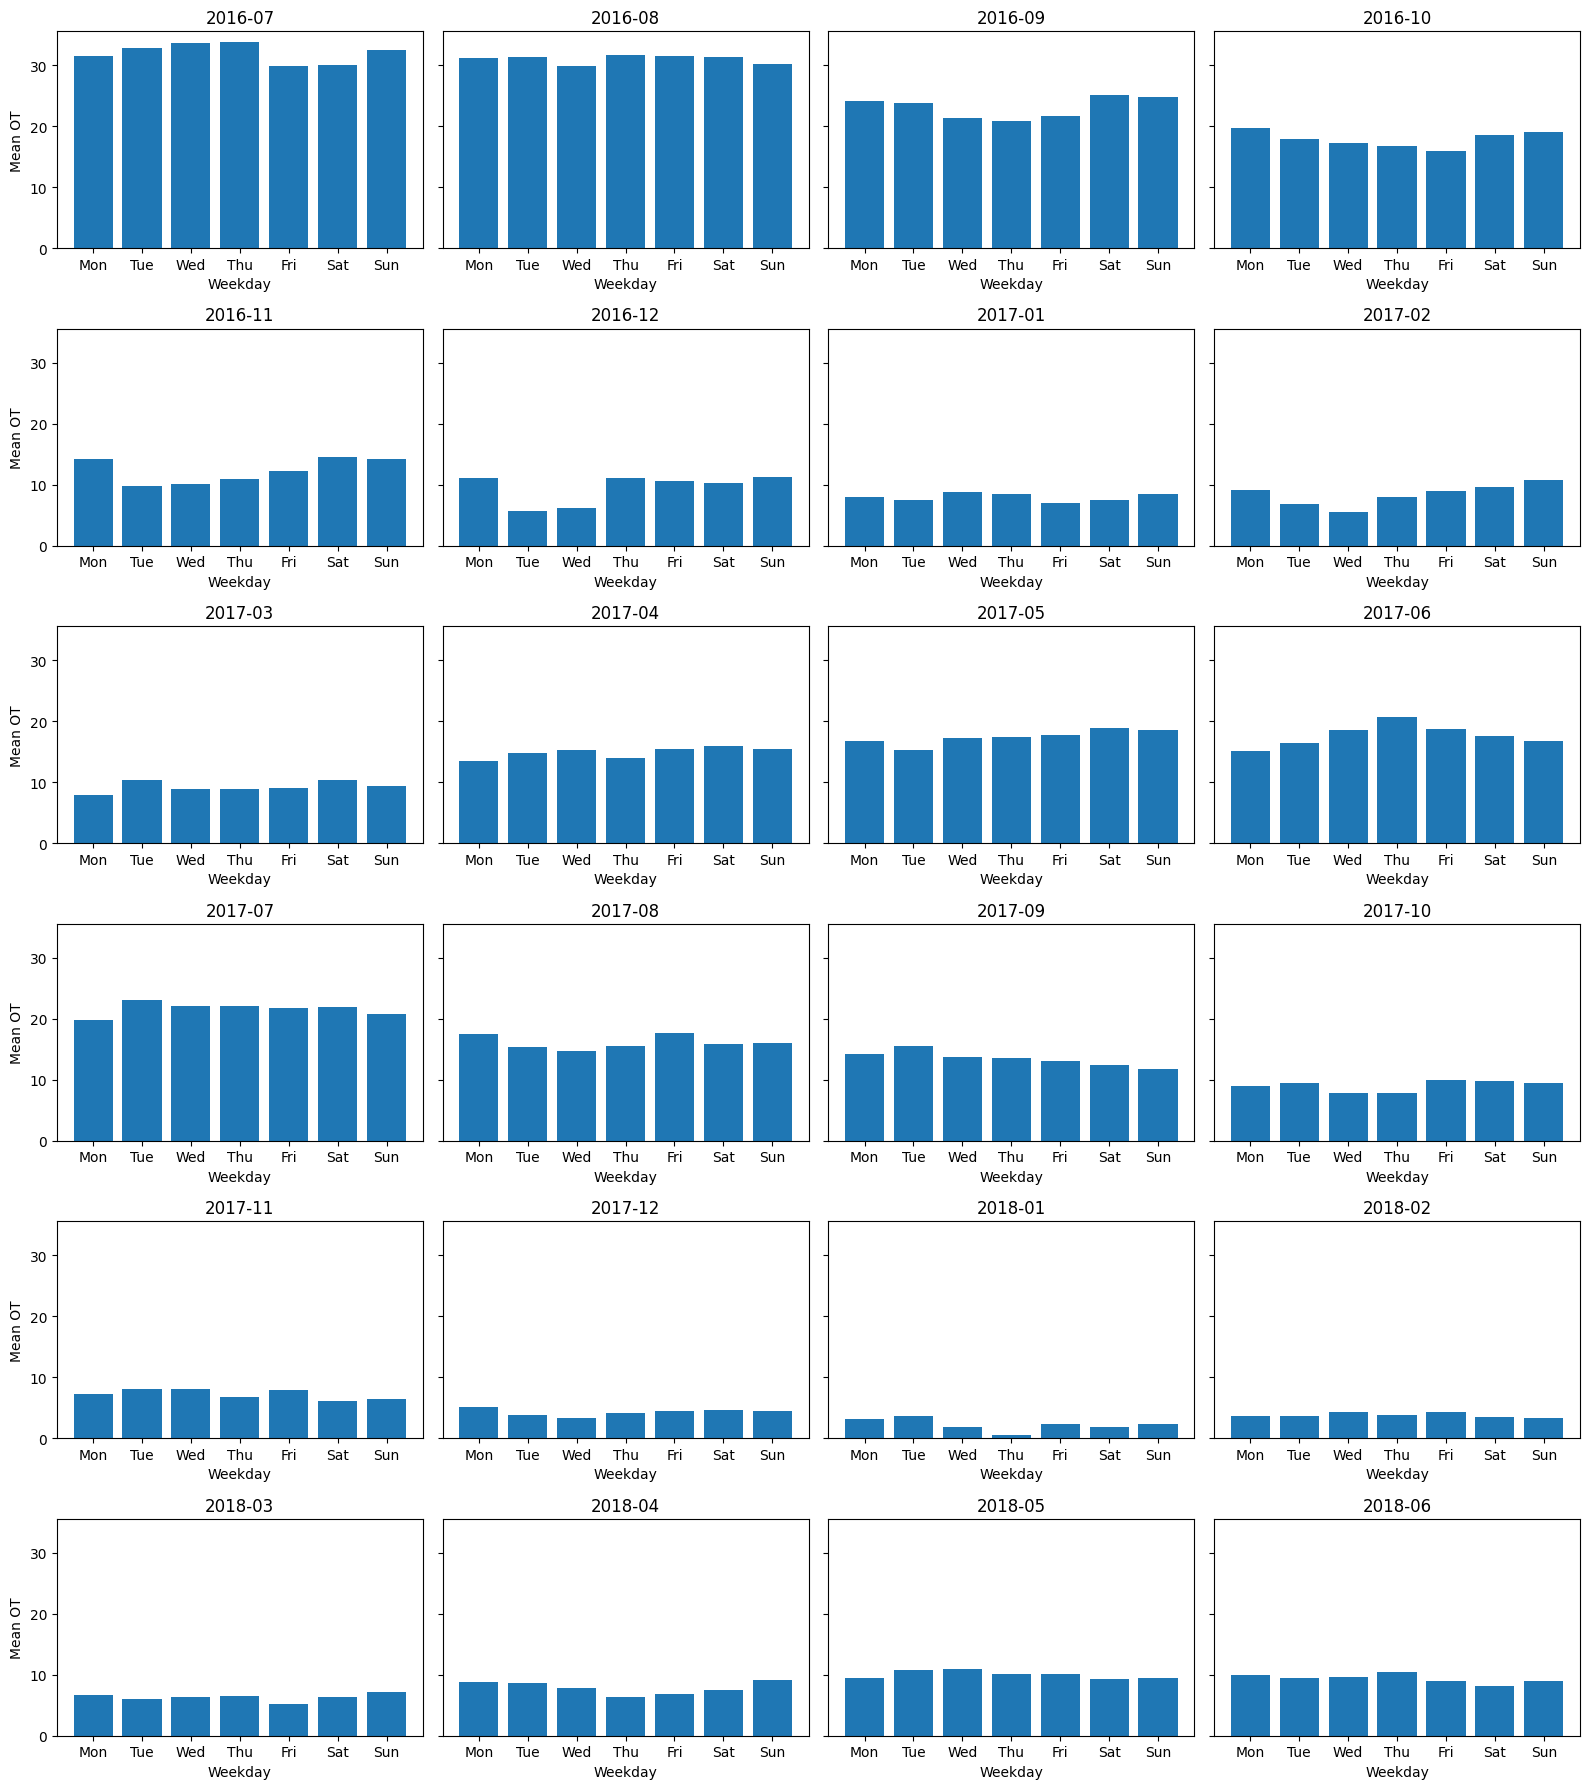

In [15]:
# Lista de meses únicos ordenados
unique_months = sorted(monthly_daily_mean['YearMonth'].unique())

# Configuración de la grid de subplots
n_months = len(unique_months)
ncols = 4   # columnas en la grid (puedes ajustar)
nrows = math.ceil(n_months / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows), sharey=True)

# Flatten para iterar fácilmente
axes = axes.flatten()

for i, ym in enumerate(unique_months):
    subset = monthly_daily_mean[monthly_daily_mean['YearMonth'] == ym]
    axes[i].bar(subset['Weekday'], subset['OT'])
    axes[i].set_title(str(ym))
    axes[i].set_xlabel("Weekday")
    if i % ncols == 0:  # solo la primera columna lleva ylabel
        axes[i].set_ylabel("Mean OT")

# Eliminar subplots vacíos
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig(FIGURES / "ot_weekly_mean_per_month.png", dpi=160)
plt.show()

Gráficos de la temperatura del transformador durante cada día de cada mes

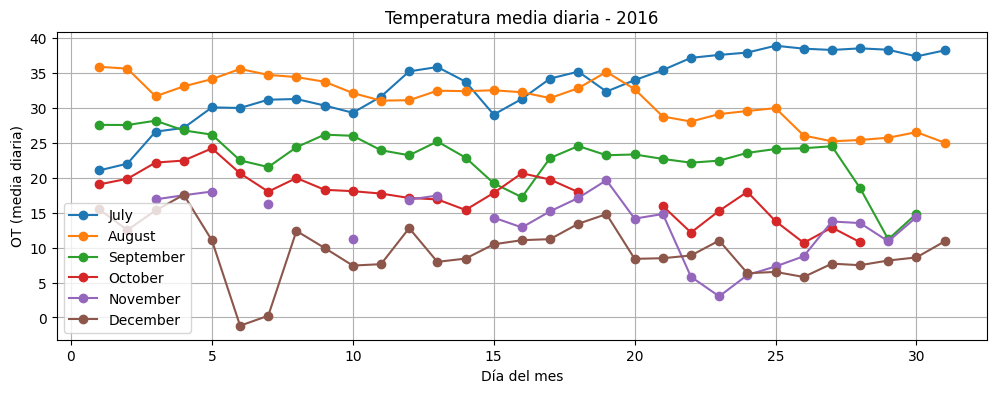

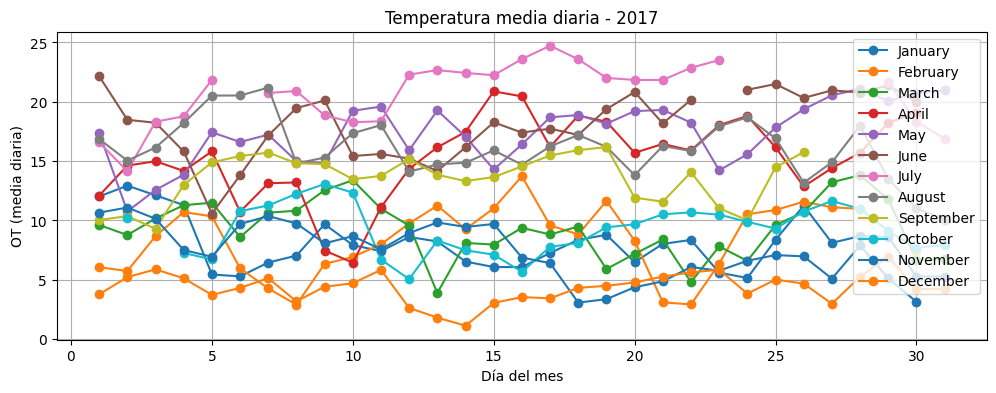

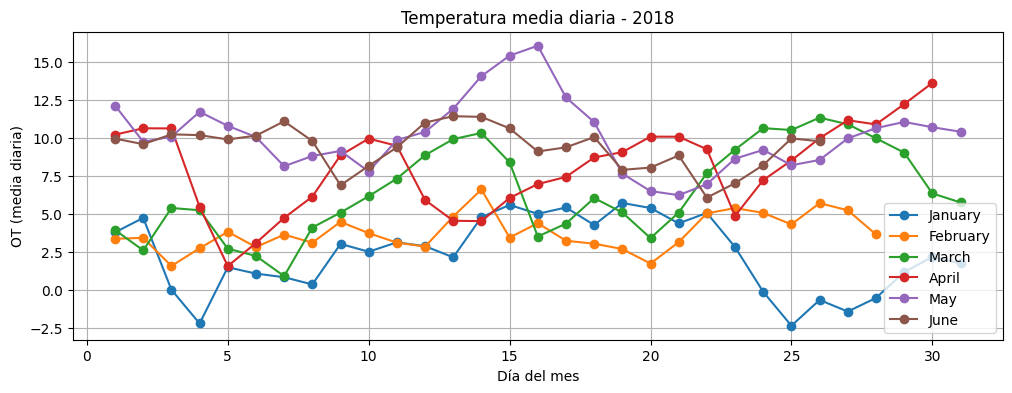

In [16]:

months = ['January','February','March', 'April', 'May','June', 
              'July', 'August', 'September', 'October', 'November', 'December']

for year in series_daily_mean.index.year.unique():
    subset = series_daily_mean[series_daily_mean.index.year == year]
    plt.figure(figsize=(12,4))
    for month in subset.index.month.unique():
        plt.plot(
            subset[subset.index.month == month].index.day,
            subset[subset.index.month == month].values,
            marker='o',
            label=str(months[month-1])
        )

    plt.title(f"Temperatura media diaria - {year}")
    plt.xlabel("Día del mes")
    plt.ylabel("OT (media diaria)")
    plt.legend()
    plt.grid(True)
    plt.savefig(FIGURES / f"mean_daily_ot_{year}", dpi=160)
    plt.show()

Al analizar la media de temperatura por día y por mes, se observa un incremento de la variable OT durante los meses de verano. Asimismo, al comparar periodos equivalentes en distintos años (por ejemplo, julio de 2016 frente a julio de 2017), se aprecia un comportamiento con patrones similares. No obstante, el aspecto más evidente de los gráficos es la tendencia descendente de la temperatura del aceite a lo largo del tiempo.

Este comportamiento constituye un primer indicio de que la variable objetivo **OT** no es estacionaria. Sin embargo, dado que únicamente se dispone de dos años de datos con frecuencia mensual, no resulta posible confirmar formalmente la no estacionariedad a partir de un patrón anual, pues sería necesario contar con una serie temporal más extensa. En este sentido, una alternativa más adecuada consiste en agrupar los datos por media diaria y comprobar empíricamente la no estacionariedad antes de avanzar en el modelado y la predicción de la temperatura diaria.

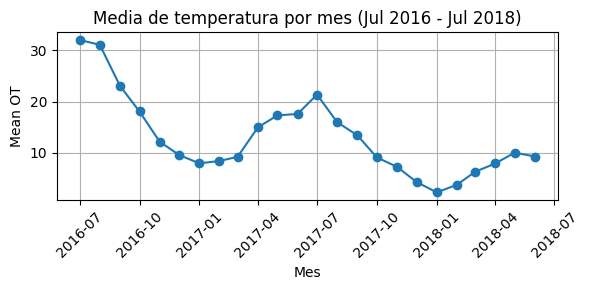

In [17]:
# Plot de media de temperatura por mes, de nuevo se puede observar la tendencia negativa.
plt.figure(figsize=(6,3))
plt.plot(monthly_mean['YearMonth'], monthly_mean['OT'], marker='o')
plt.title("Media de temperatura por mes (Jul 2016 - Jul 2018)")
plt.xlabel("Mes")
plt.ylabel("Mean OT")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 4. Comprobación de no estacionariedad de OT

Comprobación estadística de que OT es no estacionario

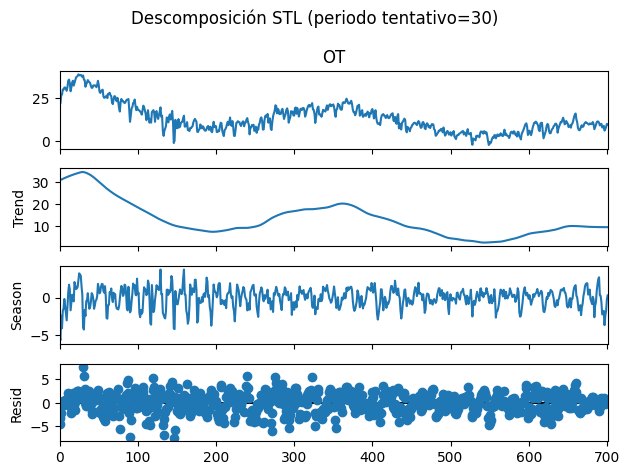

<Figure size 640x480 with 0 Axes>

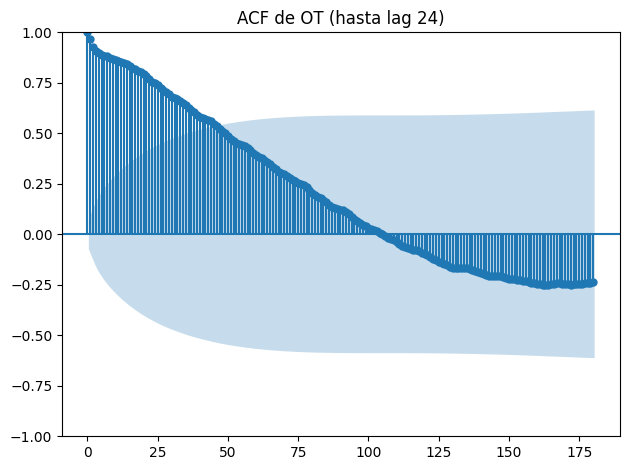

ADF p-value: 0.7302  (H0: raíz unitaria)
KPSS p-value: 0.0100 (H0: estacionariedad)
ADF no rechaza H0: posible no estacionaria.
KPSS rechaza H0: posible no estacionaria (tendencia).


C:\Users\belop\AppData\Local\Temp\ipykernel_2876\2492847394.py:23: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(y, regression="ct", nlags="auto")


In [18]:
y = daily_mean["OT"].values


# STL (periodo de 30 dias si fuera estacional mensual)
stl = STL(daily_mean["OT"], period=30)  # probar periodo mensual teórico
res = stl.fit()
fig = res.plot()
fig.suptitle("Descomposición STL (periodo tentativo=30)")
plt.tight_layout()
plt.savefig(FIGURES / "STL.png", dpi=160)
plt.show()

# ACF para buscar picos periódicos (30, 60, 180, etc.)
fig = plt.figure()
plot_acf(y, lags=180)
plt.title("ACF de OT (hasta lag 24)")
plt.tight_layout()
plt.savefig(FIGURES / "ACF.png", dpi=160)
plt.show()

# Pruebas ADF y KPSS
adf_stat, adf_p, *_ = adfuller(y, autolag="AIC", regression="ct")
kpss_stat, kpss_p, *_ = kpss(y, regression="ct", nlags="auto")

print(f"ADF p-value: {adf_p:.4f}  (H0: raíz unitaria)")
print(f"KPSS p-value: {kpss_p:.4f} (H0: estacionariedad)")

# Comentario automático
if adf_p < 0.05:
    print("ADF sugiere rechazo de H0: no hay raíz unitaria (posible estacionaria).")
else:
    print("ADF no rechaza H0: posible no estacionaria.")
if kpss_p < 0.05:
    print("KPSS rechaza H0: posible no estacionaria (tendencia).")
else:
    print("KPSS no rechaza H0: estacionaria.")

Ambos test corroboran la no estacionariedad de la variable **OT**

## 5. Partición temporal y normalización

Uso de daily_mean, datos agrupados por media de horas en cada día

In [19]:
# Reservamos los últimos 100 puntos para evaluación de predicción multi-step
import joblib


TEST_HORIZON = 100

# División de train y test
train = daily_mean.iloc[:-TEST_HORIZON].copy()
test = daily_mean.iloc[-TEST_HORIZON:].copy()

y_train = train["OT"].values.astype(float)
y_test = test["OT"].values.astype(float)

# Escalado (solo con train)
scaler = StandardScaler()
y_train_sc = scaler.fit_transform(y_train.reshape(-1,1)).ravel()
y_test_sc = scaler.transform(y_test.reshape(-1,1)).ravel()

# Guardado de scaler
joblib.dump(scaler, ARTIFACTS / 'scaler_ot_daily_mean.pkl')

print(len(y_train), len(y_test))

602 100


## 6. Estrategia de predicción 100 pasos (100 días)

In [20]:
# Usaremos una estrategia recursiva: entrenamos modelos one-step-ahead con lags de OT.
# Después, a partir del último histórico conocido, predecimos el siguiente valor y lo alimentaremos
# (feed-forward) como si fuera observado para predecir el siguiente, y así sucesivamente.

N_LAGS = 302  # 2 días como ventana inicial (ajustable)
Xtr, ytr = [], []
for i in range(N_LAGS, len(y_train_sc)):
    Xtr.append(y_train_sc[i-N_LAGS:i])
    ytr.append(y_train_sc[i])
Xtr = np.array(Xtr)
ytr = np.array(ytr)

print(Xtr.shape, ytr.shape)

(300, 302) (300,)


## 7. Modelos a comparar

In [21]:
from typing import Dict, Callable
models: Dict[str, object] = {}

# 7.1 Naive (baseline): persiste último valor
class NaiveLast:
    def __init__(self, n_lags=48):
        self.n_lags = n_lags
    def fit(self, X, y):
        return self
    def predict(self, X):
        # devuelve el último valor de la ventana (identidad)
        return X[:, -1]
models["NaiveLast"] = NaiveLast(n_lags=N_LAGS)

# 7.2 ARIMA (entrenado sobre y_train_sc). Elegimos pequeño grid.
# Para 1-step, predecimos recursivamente fuera de muestra.
arima_order_candidates = [(2,0,2), (3,0,2), (2,1,2), (3,1,2)]
best_aic = np.inf
best_order = None
best_arima = None
for order in arima_order_candidates:
    try:
        m = ARIMA(y_train_sc, order=order).fit(method_kwargs={"warn_convergence":False})
        if m.aic < best_aic:
            best_aic = m.aic
            best_order = order
            best_arima = m
    except Exception as e:
        pass
class ARIMAWrapper:
    def __init__(self, model_fit, n_lags=48):
        self.model_fit = model_fit
        self.n_lags = n_lags
    def fit(self, X, y):
        return self
    def predict(self, X):
        # 1-step ahead pred usando último estado del modelo entrenado: proxy simple
        # En fase recursiva fuera del set, usaremos simulate via rolling
        # Aquí devolvemos el último residuo + forecast 1-step de entrenamiento como aproximación
        return np.full((X.shape[0],), self.model_fit.forecast(1)[0])
models[f"ARIMA{best_order}"] = ARIMAWrapper(best_arima, n_lags=N_LAGS)

# 7.3 Holt (Exponential Smoothing)
class HoltWrapper:
    def __init__(self, y_train_sc, n_lags=48):
        self.model = ExponentialSmoothing(y_train_sc, trend='add', seasonal=None).fit()
        self.n_lags = n_lags
    def fit(self, X, y):
        return self
    def predict(self, X):
        # usar forecast 1-step constante como proxy para lotes
        f = self.model.forecast(1)[0]
        return np.full((X.shape[0],), f)
models["Holt"] = HoltWrapper(y_train_sc, n_lags=N_LAGS)

# 7.4 RandomForest
rf = RandomForestRegressor(n_estimators=300, max_depth=12, random_state=42, n_jobs=-1)
models["RandomForest"] = rf

# 7.5 XGBoost
xgb = XGBRegressor(
    n_estimators=600,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    reg_lambda=1.0,
)
models["XGBoost"] = xgb

# 7.6 LSTM (opcional; puede ser más lento)
try:

    def build_lstm(n_lags=48):
        model = keras.Sequential([
            layers.Input((n_lags, 1)),
            layers.LSTM(64, return_sequences=False),
            layers.Dense(32, activation='relu'),
            layers.Dense(1)
        ])
        model.compile(optimizer=keras.optimizers.Adam(1e-3), loss='mse')
        return model
    models["LSTM"] = "placeholder"
except Exception as e:
    print("TensorFlow no disponible:", e)

list(models.keys())

c:\Users\belop\Documents\Trabajo\Capgemini\CBL-TestDataScience-2\.prueba_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\belop\Documents\Trabajo\Capgemini\CBL-TestDataScience-2\.prueba_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


['NaiveLast', 'ARIMA(2, 1, 2)', 'Holt', 'RandomForest', 'XGBoost', 'LSTM']

## 8. Entrenamiento (one-step)

In [22]:
results = {}

# Preparación para LSTM
Xtr_lstm = Xtr.reshape((Xtr.shape[0], Xtr.shape[1], 1))

for name, model in models.items():
    if name == "LSTM":
        m = build_lstm(N_LAGS)
        m.fit(Xtr_lstm, ytr, epochs=10, batch_size=128, verbose=0, validation_split=0.1)
        models[name] = m  # replace placeholder
        results[name] = {"status": "trained"}
    else:
        model.fit(Xtr, ytr)
        # store attribute n_lags for demo script
        if hasattr(model, "n_estimators") or hasattr(model, "predict"):
            setattr(model, "n_lags", N_LAGS)
        results[name] = {"status": "trained"}

results

{'NaiveLast': {'status': 'trained'},
 'ARIMA(2, 1, 2)': {'status': 'trained'},
 'Holt': {'status': 'trained'},
 'RandomForest': {'status': 'trained'},
 'XGBoost': {'status': 'trained'},
 'LSTM': {'status': 'trained'}}

## 9. Predicción recursiva de 100 pasos

In [23]:
def recursive_forecast(model, last_hist_scaled, n_steps=100, is_lstm=False):
    hist = list(last_hist_scaled)  # last N_LAGS values, scaled
    preds = []
    for _ in range(n_steps):
        x = np.array(hist[-N_LAGS:])
        if is_lstm:
            x_in = x.reshape(1, N_LAGS, 1)
            yhat = float(model.predict(x_in, verbose=0).ravel()[0])
        else:
            x_in = x.reshape(1, -1)
            yhat = float(model.predict(x_in).ravel()[0])
        preds.append(yhat)
        hist.append(yhat)
    return np.array(preds)

hist_window = y_train_sc[-N_LAGS:]

preds_dict = {}
for name, model in models.items():
    if name.startswith("ARIMA"):
        # For ARIMA/Holt we use their 1-step forecast in a recursive fashion by refitting rolling.
        # Simple strategy: persist last value or use a small wrapper; we fallback to Naive-like behavior
        # if direct recursive with internal state is not straightforward in batch.
        # Here we approximate with recursive using last window + model 1-step.
        preds_sc = recursive_forecast(model, hist_window, n_steps=100, is_lstm=False)
    elif name == "Holt":
        preds_sc = recursive_forecast(model, hist_window, n_steps=100, is_lstm=False)
    elif name == "LSTM":
        preds_sc = recursive_forecast(model, hist_window, n_steps=100, is_lstm=True)
    else:
        preds_sc = recursive_forecast(model, hist_window, n_steps=100, is_lstm=False)
    preds = scaler.inverse_transform(preds_sc.reshape(-1,1)).ravel()
    preds_dict[name] = preds

# Añadimos baseline Naive directo usando último valor observado
last_obs = y_train[-1]
preds_dict["NaiveRepeat"] = np.repeat(last_obs, 100)

list(preds_dict.keys())

['NaiveLast',
 'ARIMA(2, 1, 2)',
 'Holt',
 'RandomForest',
 'XGBoost',
 'LSTM',
 'NaiveRepeat']

### Predicción directa (no recursiva)

In [24]:
# ARIMA: re-fit sobre todo el y_train_sc si no lo has guardado
arima_fit = ARIMA(y_train_sc, order=best_order).fit()
arima_preds_sc = arima_fit.forecast(steps=TEST_HORIZON)  # devuelve array (h,)
arima_preds = scaler.inverse_transform(arima_preds_sc.reshape(-1,1)).ravel()

# Holt (ExponentialSmoothing)
holt_model = ExponentialSmoothing(y_train_sc, trend='add', seasonal=None).fit()
holt_preds_sc = holt_model.forecast(TEST_HORIZON)
holt_preds = scaler.inverse_transform(holt_preds_sc.reshape(-1,1)).ravel()

preds_dict["ARIMA_no_Recursive"] = arima_preds
preds_dict["Holt_no_Recursive"] = holt_preds

## 10. Evaluación con KPIs y comparación

In [25]:
def compute_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-8))) * 100.0
    return mae, rmse, mape

scores = []
for name, preds in preds_dict.items():
    mae, rmse, mape = compute_metrics(y_test, preds)
    scores.append((name, mae, rmse, mape))

scores_df = pd.DataFrame(scores, columns=["Modelo", "MAE", "RMSE", "MAPE"]).sort_values("RMSE")
scores_df.to_csv(REPORTS / 'scores_df.csv', index=False)
scores_df

Modelo       MAE      RMSE       MAPE
4             XGBoost  1.992506  2.504265  25.776200
5                LSTM  2.481418  2.942341  30.162100
1      ARIMA(2, 1, 2)  3.091598  3.592667  34.826173
7  ARIMA_no_Recursive  3.240885  3.754269  35.997380
0           NaiveLast  3.376388  3.901175  37.013833
6         NaiveRepeat  3.376388  3.901175  37.013833
2                Holt  3.395377  3.920474  37.174691
3        RandomForest  3.514913  4.056638  37.826475
8   Holt_no_Recursive  4.545434  5.090525  48.913669

### Gráfico comparativo (real vs. mejor modelo)

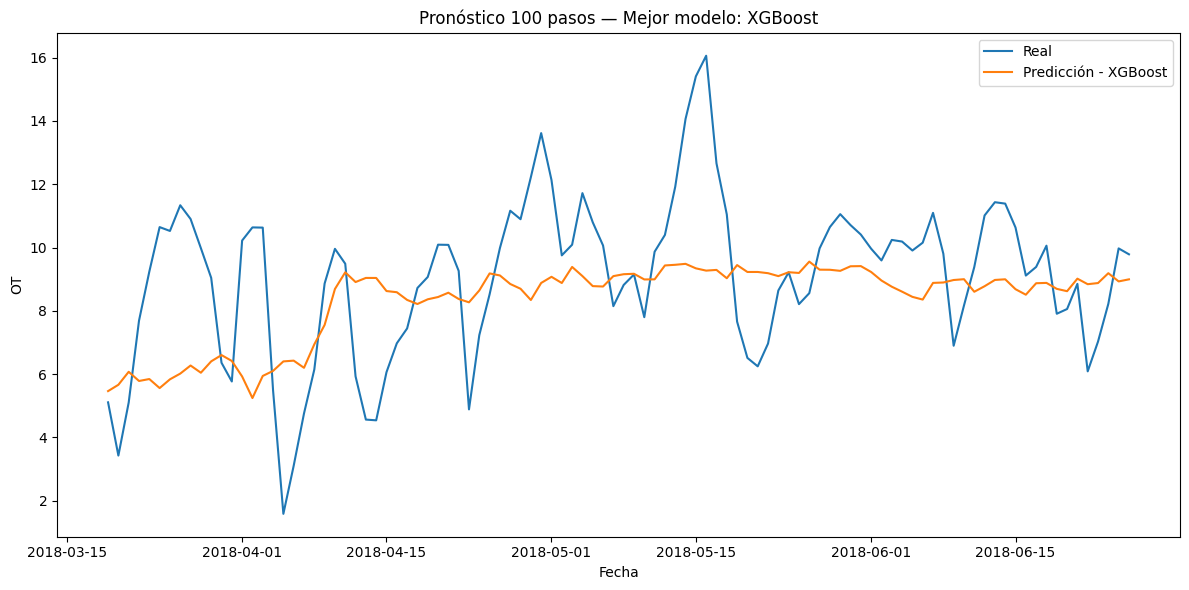

'XGBoost'

In [26]:
best_name = scores_df.iloc[0]["Modelo"]
best_preds = preds_dict[best_name]

plt.figure(figsize=(12,6))
plt.plot(test["Day"], y_test, label="Real")
plt.plot(test["Day"], best_preds, label=f"Predicción - {best_name}")
plt.title(f"Pronóstico 100 pasos — Mejor modelo: {best_name}")
plt.xlabel("Fecha")
plt.ylabel("OT")
plt.legend()
plt.tight_layout()
plt.savefig(FIGURES / "best_forecast.png", dpi=160)
plt.show()

best_name

## 11. Conclusión

Las series temporales no estacionarias suelen presentar una mayor complejidad en el proceso de predicción de evolución futura. A diferencia de las series estacionarias, en las que existen patrones claros y recurrentes, las series no estacionarias muestran una elevada irregularidad en los valores, lo que puede conllevar cambios abruptos e impredecibles.

En el caso del presente análisis, el dataset correspondiente a dos transformadores eléctricos —con atributos asociados a carga útil/inútil y carga alta/baja— contiene una variable objetivo (Oil Temperature) que se comporta de manera claramente no estacionaria tanto en periodos mensuales como, aparentemente, en escalas anuales.

Para abordar la tarea de predicción de los 100 periodos temporales establecidos, se llevó a cabo un proceso de visualización y limpieza de los datos. Posteriormente, a partir de un análisis exploratorio mediante gráficos y estadísticas descriptivas, se optó por realizar la predicción de la temperatura media diaria, considerando los últimos 100 días como conjunto de prueba.

Se evaluaron siete algoritmos de predicción: NaiveLast, ARIMA(2,1,2), Holt, Random Forest, XGBoost, LSTM y NaiveRepeat. En el caso de Holt y ARIMA, se implementaron dos configuraciones: predicciones recursivas de un día en un día y predicción directa de los 100 días. El tamaño de ventana empleado para el entrenamiento fue de 300 días, con el fin de aprovechar al máximo la limitada cantidad de datos disponible.

Entre todos los modelos, XGBoost obtuvo los mejores resultados en términos de métricas de evaluación (MAE, MAPE y RMSE). Sin embargo, a pesar de superar al resto de algoritmos, su rendimiento no alcanza niveles óptimos: el MAPE obtenido fue del 25%, cuando lo recomendable en tareas de predicción suele ser un valor inferior al 5%.

No obstante, el análisis visual de las predicciones revela que XGBoost consigue capturar la tendencia global de la serie, reproduciendo adecuadamente los incrementos de temperatura en periodos específicos. Un ejemplo representativo se observa alrededor del 10 de abril de 2018, donde el modelo refleja el aumento de la temperatura del aceite atribuido a la proximidad del verano, lo que indica una capacidad para identificar patrones estacionales de carácter aproximado.

En conclusión, aunque el modelo de predicción basado en XGBoost muestra utilidad para anticipar la tendencia media mensual de la temperatura, las fuertes fluctuaciones de la serie limitan su capacidad de estimar con precisión los valores diarios.

## 11. Guardado del mejor modelo y demostración de carga

In [27]:
import joblib

best_model_obj = models.get(best_name, None)
# Guardamos el mejor modelo + scaler juntos
bundle_path = ARTIFACTS / "best_model.joblib"
joblib.dump({"model": best_model_obj, "scaler": scaler}, bundle_path)
bundle_path

WindowsPath('C:/Users/belop/Documents/Trabajo/Capgemini/CBL-TestDataScience-2/artifacts/best_model.joblib')

Puedes ejecutar la demo de inferencia desde terminal:

```bash
python src/demo_inferencia.py
```